# Assignment 2
## Stochastic and Spatial Models
---
Peterson, Victoria J  
*ID: 15476758* 

Beumer, Wessel T L
*ID: 12640662*

University of Amsterdam  
*Introduction to Computational Science, Block 1, 2024*  

Due: 27 October 2024

---

In [4]:
import numpy as np
from scipy.integrate import odeint 
from scipy.fft import fft, fftfreq, fftshift
from scipy.signal import find_peaks
import networkx as nx
# import ndlib.models.epidemics as ep
import dataclasses
import matplotlib.pyplot as plt

from alive_progress import alive_bar
import logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger("alive_progress")

In [5]:
@dataclasses.dataclass
class Results:
    S_List: list[int]
    I_List: list[int]
    R_List: list[int]
    time: list[float]

In [6]:
class Event:
    dX = 0.0
    dY = 0.0
    dZ = 0.0
    rate = 0.0


class Transmission(Event):
    def __init__(self, beta, X, Y, Z, N):
        self.dX = -1
        self.dY = 1
        self.dZ = 0
        self.rate = beta*X*Y/N

class Births(Event):
    def __init__(self, mu, X, Y, Z, N):
        self.dX = 1
        self.dY = 0
        self.dZ = 0
        self.rate = mu*N

class DeathsX(Event):
    def __init__(self, mu, X, Y, Z, N):
        self.dX = -1
        self.dY = 0.0
        self.dZ = 0.0
        self.rate = mu*X

class DeathsY(Event):
    def __init__(self, mu, X, Y, Z, N):
        self.dX = 0.0
        self.dY = -1
        self.dZ = 0.0
        self.rate = mu*Y

class DeathsZ(Event):
    def __init__(self, mu, X, Y, Z, N):
        self.dX = 0.0
        self.dY = 0.0
        self.dZ = -1
        self.rate = mu*Z

class Recovery(Event):
    def __init__(self, gamma, X, Y, Z, N):
        self.dX = 0.0
        self.dY = -1
        self.dZ = 1
        self.rate = gamma*Y

In [7]:
class SIRModelGillespies:
    def __init__ (self, X, Y, Z, N, beta, gamma, mu):
        
        self.X = X
        self.Y = Y
        self.Z = Z
        self.N = N
        self.beta = beta
        self.gamma = gamma
        self.mu = mu
        self.results = Results([], [], [], [])

    def calcEvents(self):
        events = []
        events.append(Transmission(self.beta, self.X, self.Y, self.Z, self.N))
        events.append(Births(self.mu, self.X, self.Y, self.Z, self.N))
        events.append(DeathsX(self.mu, self.X, self.Y, self.Z, self.N))
        events.append(DeathsY(self.mu, self.X, self.Y, self.Z, self.N))
        events.append(DeathsZ(self.mu, self.X, self.Y, self.Z, self.N))
        events.append(Recovery(self.gamma, self.X, self.Y, self.Z, self.N))
        return events

    def gillespiesAlgorithm(self):
        events = self.calcEvents()
        rateTotal = sum([i.rate for i in events])

        deltaT = -1/rateTotal * np.log(np.random.rand())

        probabilities = np.random.rand() * rateTotal

        upperRate = 0

        for i in events:
            lowerRate = upperRate
            upperRate += i.rate

            if lowerRate < probabilities <= upperRate:
                return i, deltaT


    def gillespiesSimulation(self, finalTime):
        time = 0

        while time < finalTime:
            event, deltaT = self.gillespiesAlgorithm()
            time += deltaT

            self.X += event.dX
            self.Y += event.dY
            self.Z += event.dZ

            self.results.S_List.append(self.X)
            self.results.I_List.append(self.Y)
            self.results.R_List.append(self.Z)
            self.results.time.append(time)


In [8]:
class SIRModelDeterministic:
    def __init__ (self, X, Y, Z, N, beta, gamma, mu, timeInterval, timeFinal):
        
        self.X = X
        self.Y = Y
        self.Z = Z
        self.N = N
        self.beta = beta
        self.gamma = gamma
        self.mu = mu
        self.timeInterval = timeInterval
        self.timeFinal = timeFinal
        self.results = Results([], [], [], [])

    def SIRModel(self):
        timeSpan = np.arange(0, self.timeFinal, step = self.timeInterval)

        S = np.zeros(round(self.timeFinal/self.timeInterval))
        I = np.zeros(round(self.timeFinal/self.timeInterval))
        R = np.zeros(round(self.timeFinal/self.timeInterval))

        S[0], I[0], R[0] = self.X, self.Y, self.Z

        for t in range(1, len(timeSpan)):
            dSdt = self.mu * (self.N - S[t-1]) - self.beta * S[t-1] * I[t-1] / self.N
            dIdt = self.beta * S[t-1] * I[t-1] / self.N - self.gamma * I[t-1] - self.mu * I[t-1]
            dRdt = self.gamma * I[t-1] - self.mu * R[t-1]

            S[t] = S[t-1] + self.timeInterval * dSdt
            I[t] = I[t-1] + self.timeInterval * dIdt
            R[t] = R[t-1] + self.timeInterval * dRdt

        self.results.S_List = S
        self.results.I_List = I
        self.results.R_List = R
        self.results.time = timeSpan

            


In [9]:
def fourierOnSeries(series, averageTimeStepSize, height = 1e5, width = 2):
    I_array = np.array(series)
    I_array -= I_array.mean()

    fourier_analysis = np.array(fft(I_array))
    freqs = fftfreq(len(I_array), d=averageTimeStepSize)
    fourier_analysis = np.abs(np.real(fourier_analysis))

    peaks, peak_properties = find_peaks(fourier_analysis, height=height, width=width )

    plt.plot(freqs, fourier_analysis, "g.", label="Fourier Transformation")
    for peak in peaks:
        if freqs[peak] >= 0:
            plt.plot(freqs[peak], fourier_analysis[peak], "ro", label=f"Peak {round(freqs[peak], 6)}") #type: ignore
    plt.xlim(0, 0.1)
    plt.title("Fourier analysis of Infected fraction")
    plt.xlabel("Frequency")
    plt.ylabel("Intensity")
    plt.legend()
    plt.show()

In [8]:
# Initial Values
X0 = 999
Y0 = 1
Z0 = 0
N = X0 + Y0 + Z0
beta = 0.5
gamma = 0.1
mu = 0.005

maxTime = 1000


model = SIRModelGillespies(X0, Y0, Z0, N, beta, gamma, mu)

model.gillespiesSimulation(maxTime)

#for i in range(len(model.results.time)):
#    print(model.results.time[i], model.results.S_List[i], model.results.I_List[i], model.results.R_List[i])


deterministicModel = SIRModelDeterministic(X0, Y0, Z0, N, beta, gamma, mu, 1, maxTime)

deterministicModel.SIRModel()

# for i in range(len(deterministicModel.results.time)):
#     print(deterministicModel.results.time[i], deterministicModel.results.S_List[i], deterministicModel.results.I_List[i], deterministicModel.results.R_List[i])

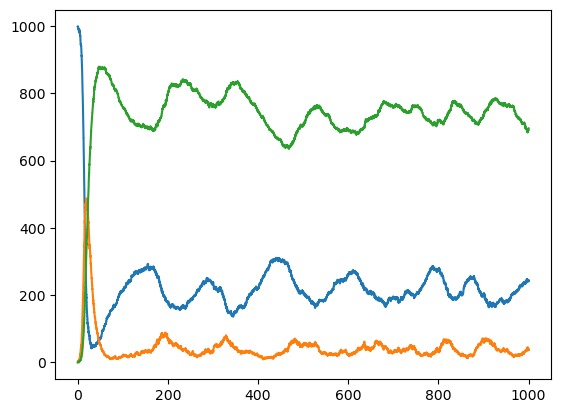

In [9]:
plt.figure()
plt.plot(model.results.time, model.results.S_List, label='S')
plt.plot(model.results.time, model.results.I_List, label='I')
plt.plot(model.results.time, model.results.R_List, label='R')

plt.show()

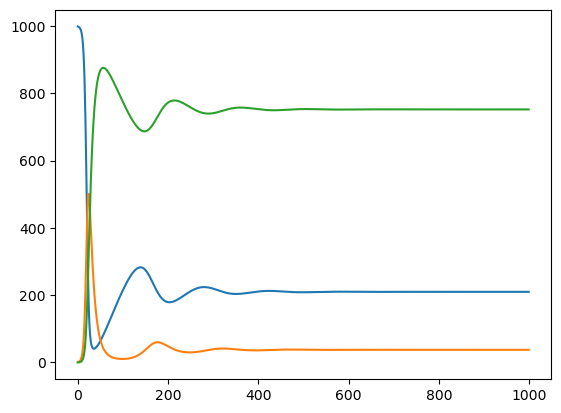

In [11]:
plt.figure()
plt.plot(deterministicModel.results.time, deterministicModel.results.S_List, label='S')
plt.plot(deterministicModel.results.time, deterministicModel.results.I_List, label='I')
plt.plot(deterministicModel.results.time, deterministicModel.results.R_List, label='R')
# plt.plot(deterministicModel.results.time, sinewave(deterministicModel.results.time))
plt.show()

# Fourier analysis of stochastic model

len(model.results.time) = 516247


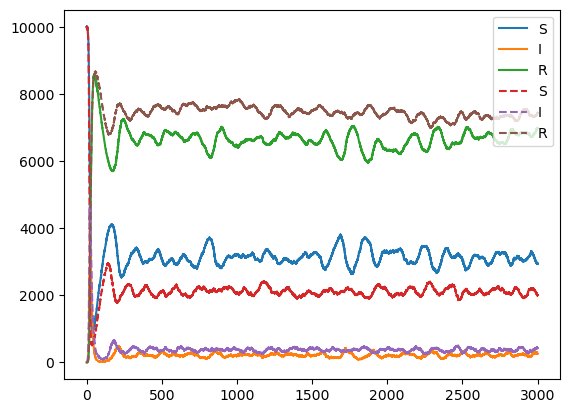

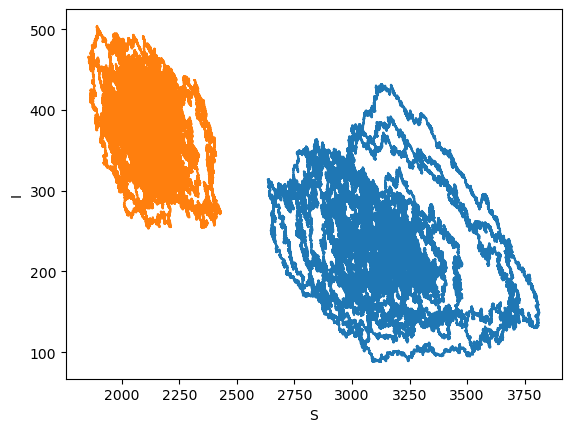

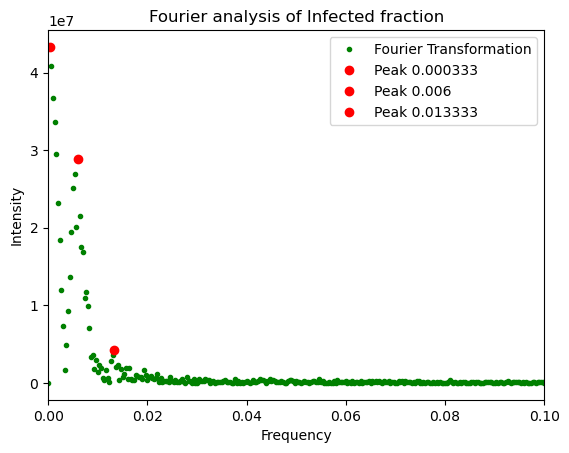

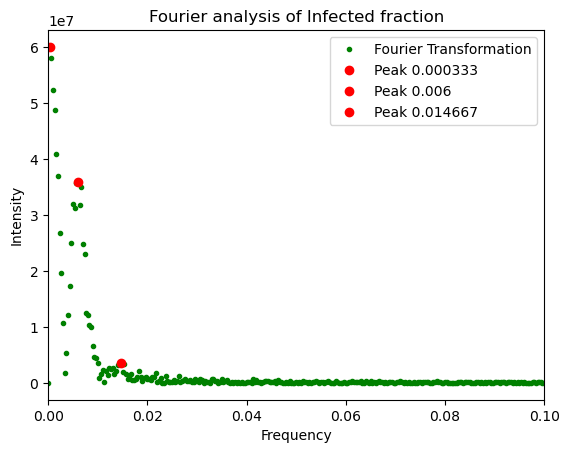

len(model.results.I_List) = 516247
len(model2.results.I_List) = 545380


In [13]:
# Initial Values
X0 = 9995 
Y0 = 5
# X0 = 1000
# Y0 = 0
Z0 = 0
N = X0 + Y0 + Z0
beta = 0.5
gamma = 0.15
mu = 0.005
maxTime = 3000

model = SIRModelGillespies(X0, Y0, Z0, N, beta, gamma, mu)
model2 = SIRModelGillespies(X0, Y0, Z0, N, beta, 0.1, mu)
model.gillespiesSimulation(maxTime)
model2.gillespiesSimulation(maxTime)

print(f"{len(model.results.time) = }")
plt.plot(model.results.time, model.results.S_List, "-", label='S')
plt.plot(model.results.time, model.results.I_List, "-", label='I')
plt.plot(model.results.time, model.results.R_List, "-", label='R')
plt.plot(model2.results.time, model2.results.S_List, "--", label='S')
plt.plot(model2.results.time, model2.results.I_List, "--", label='I')
plt.plot(model2.results.time, model2.results.R_List, "--", label='R')
plt.legend(loc="upper right")
plt.show()

averageTimeStepSize = np.diff(np.array(model.results.time)).mean()
averageTimeStepSize2 = np.diff(np.array(model2.results.time)).mean()
t500 = round(800/averageTimeStepSize)
plt.plot(model.results.S_List[t500:], model.results.I_List[t500:])
plt.plot(model2.results.S_List[t500:], model2.results.I_List[t500:])
plt.xlabel("S")
plt.ylabel("I")
plt.show()


fourierOnSeries(model.results.I_List, averageTimeStepSize, height=1e6, width=3)
fourierOnSeries(model2.results.I_List, averageTimeStepSize2, height=1e6, width=3)
print(f"{len(model.results.I_List) = }")
print(f"{len(model2.results.I_List) = }")

In [10]:
# Initial Values
X0 = 9995 
Y0 = 5
# X0 = 1000
# Y0 = 0
Z0 = 0
N = X0 + Y0 + Z0
beta = 0.3
# gamma = 0.1
mu = 0.005
maxTime = 1000

gamma_space = np.linspace(0.04, 0.16, 40)
gamma_limit_1k = 32
R0_space = beta / gamma_space

|█████████████████████████████████████▍⚠︎ | (!) 560/600 [93%] in 23:10.5 (0.40/s)


[]

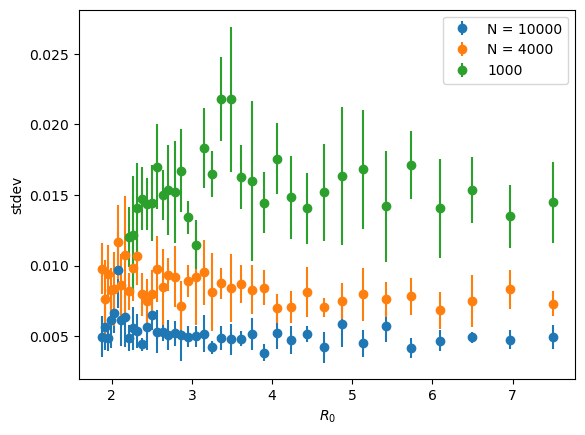

In [12]:
# Initial Values
X0 = 9995 
Y0 = 5
# X0 = 1000
# Y0 = 0
Z0 = 0
N = X0 + Y0 + Z0
beta = 0.3
# gamma = 0.1
mu = 0.005
maxTime = 1000

gamma_space = np.linspace(0.04, 0.16, 40)
gamma_limit_1k = 32
R0_space = beta / gamma_space

with alive_bar(15*len(gamma_space), force_tty=True) as bar:
    stdev_list_10k = []
    stdev_std_10k = []
    X0 = 9995
    N = X0 + Y0 + Z0
    for gamma in gamma_space:
        samples = 5
        stdev = np.zeros(samples)
        while samples > 0:
            model = SIRModelGillespies(X0, Y0, Z0, N, beta, gamma, mu)
            model.gillespiesSimulation(maxTime)
            if model.results.I_List[-1] == 0:
                continue
            averageTimeStepSize = np.diff(np.array(model.results.time)).mean()
            measureStartTime = round(500/averageTimeStepSize)
            stdev[samples - 1] = np.std(np.array(model.results.I_List)[measureStartTime:]) / N
            samples -= 1
            bar()
        stdev_std_10k.append(np.std(stdev))
        stdev_list_10k.append(stdev.mean())
    plt.errorbar(R0_space, stdev_list_10k, yerr=stdev_std_10k, fmt="o", label="N = 10000")

    stdev_list_4k = []
    stdev_std_4k = []
    X0 = 3995
    N = X0 + Y0 + Z0
    for gamma in gamma_space:
        samples = 5
        stdev = np.zeros(samples)
        while samples > 0:
            model = SIRModelGillespies(X0, Y0, Z0, N, beta, gamma, mu)
            model.gillespiesSimulation(maxTime)
            if model.results.I_List[-1] == 0:
                continue
            averageTimeStepSize = np.diff(np.array(model.results.time)).mean()
            measureStartTime = round(500/averageTimeStepSize)
            stdev[samples - 1] = np.std(np.array(model.results.I_List)[measureStartTime:]) / N
            samples -= 1
            bar()
        stdev_std_4k.append(np.std(stdev))
        stdev_list_4k.append(stdev.mean())
    plt.errorbar(R0_space, stdev_list_4k, yerr=stdev_std_4k, fmt="o", label="N = 4000")

    stdev_list_1k = []
    stdev_std_1k = []
    X0 = 995
    N = X0 + Y0 + Z0
    for gamma in gamma_space[0:gamma_limit_1k]:
        samples = 5
        stdev = np.zeros(samples)
        while samples > 0:
            model = SIRModelGillespies(X0, Y0, Z0, N, beta, gamma, mu)
            model.gillespiesSimulation(maxTime)
            if model.results.I_List[-1] == 0:
                continue
            averageTimeStepSize = np.diff(np.array(model.results.time)).mean()
            measureStartTime = round(500/averageTimeStepSize)
            stdev[samples - 1] = np.std(np.array(model.results.I_List)[measureStartTime:]) / N
            samples -= 1
            bar()
        stdev_std_1k.append(np.std(stdev))
        stdev_list_1k.append(stdev.mean())
    plt.errorbar(R0_space[0:gamma_limit_1k], stdev_list_1k, yerr=stdev_std_1k, fmt="o", label="N = 1000")


plt.xlabel("$R_0$")
plt.ylabel("stdev")
plt.legend()
plt.plot()
    # averageTimeStepSize = np.diff(np.array(model.results.time)).mean()
    # fourierOnSeries(model.results.I_List, averageTimeStepSize, height=1e6, width=1)

In [12]:
print(f"{stdev_list_10k = }")
print(f"{stdev_std_10k = }")
print(f"{stdev_list_4k = }")
print(f"{stdev_std_4k = }")
print(f"{stdev_list_1k = }")
print(f"{stdev_std_1k = }")

stdev_list_10k = [0.004959858354018354, 0.004743876467561756, 0.004898370835138705, 0.004684301081192487, 0.004155044353973891, 0.00568448468867324, 0.004496979286803243, 0.005883860679409077, 0.004221153849127088, 0.0051461407638835905, 0.004722606020607795, 0.005245024124079868, 0.0038288096486092287, 0.0051496280156170145, 0.004809310500697166, 0.004757909241239785, 0.004859661095635735, 0.004193119887279197, 0.0051620612624156195, 0.004978879127939639, 0.004948140388174969, 0.005045872740953895, 0.005191025868009999, 0.005078114094737452, 0.0053212379628908525, 0.0052961325546373676, 0.006483354973774247, 0.005651392198617071, 0.004421593784495538, 0.005378992782719703, 0.005559854653443849, 0.004872886869404151, 0.006364448676462258, 0.006171311483466957, 0.009695790799686098, 0.006607763380951978, 0.006136063854810013, 0.00484922077712622, 0.005628000791970076, 0.00495394126999534]
stdev_std_10k = [0.0008586337340403784, 0.0006685768724778952, 0.00042420268044531537, 0.0007104196

In [11]:
stdev_list_10k = [0.004959858354018354, 0.004743876467561756, 0.004898370835138705, 0.004684301081192487, 0.004155044353973891, 0.00568448468867324, 0.004496979286803243, 0.005883860679409077, 0.004221153849127088, 0.0051461407638835905, 0.004722606020607795, 0.005245024124079868, 0.0038288096486092287, 0.0051496280156170145, 0.004809310500697166, 0.004757909241239785, 0.004859661095635735, 0.004193119887279197, 0.0051620612624156195, 0.004978879127939639, 0.004948140388174969, 0.005045872740953895, 0.005191025868009999, 0.005078114094737452, 0.0053212379628908525, 0.0052961325546373676, 0.006483354973774247, 0.005651392198617071, 0.004421593784495538, 0.005378992782719703, 0.005559854653443849, 0.004872886869404151, 0.006364448676462258, 0.006171311483466957, 0.009695790799686098, 0.006607763380951978, 0.006136063854810013, 0.00484922077712622, 0.005628000791970076, 0.00495394126999534]
stdev_std_10k = [0.0008586337340403784, 0.0006685768724778952, 0.00042420268044531537, 0.0007104196832160738, 0.0006996974232648312, 0.00112357500755665, 0.0009572879968022667, 0.001672683727565759, 0.001097262087841044, 0.0005555144793677902, 0.0009991932010291935, 0.0011346821590295915, 0.0005746180528563154, 0.001144296798706055, 0.000540009022591237, 0.001094060673813266, 0.0008640432794418069, 0.00048798088278510413, 0.0013085396806573556, 0.0007426192502188919, 0.0007373302281825199, 0.0018178133149826423, 0.0008885567330233175, 0.0010933882197448831, 0.000666107845843602, 0.0015167701278315754, 0.0010827525726460085, 0.001656953740165504, 0.0004659008688571083, 0.0012059214884178509, 0.0015199605176146604, 0.0009012348607567119, 0.002171885014911252, 0.0018705139104544723, 0.0026987560236773106, 0.0013965769926658413, 0.001984184419699762, 0.000906883116056877, 0.0016327350275237508, 0.0014601680801896316]
stdev_list_4k = [0.007282265267701341, 0.008307426805462119, 0.007476432278896626, 0.006818008877745732, 0.00782386766376288, 0.007591927153707346, 0.007958964935353788, 0.007481063250067789, 0.007026010671189896, 0.00813278861630667, 0.007063255232162569, 0.006954830374870829, 0.008435085930499969, 0.008293736740117545, 0.008696912332997284, 0.008372514291664858, 0.008731993246649684, 0.008134028842720277, 0.009510009208885544, 0.009176190895883483, 0.008914629786227465, 0.007160257665719457, 0.0092157786010864, 0.009358875789073953, 0.008474609250694138, 0.009753401142902823, 0.007975532619521579, 0.0074968623420534454, 0.007957873073287861, 0.01065881901257804, 0.009855023878990829, 0.008173523987527475, 0.010757820524042639, 0.008610538613891109, 0.011665831934722705, 0.008343147904381353, 0.008247288594664929, 0.009411009438762743, 0.0076105154221603145, 0.009763611616476613]
stdev_std_4k = [0.0008891176711303414, 0.001371403968630731, 0.0018446830278401947, 0.0013131139252341418, 0.001297851840674113, 0.0012461895226391156, 0.0018569993406758031, 0.001273244641548585, 0.0007024579721576439, 0.0017546950411827422, 0.0011342630443357134, 0.0010483660622781514, 0.0012543081836387828, 0.001725166027950226, 0.0013337262551456849, 0.002408618509984472, 0.0011156992176686333, 0.0027693271535476015, 0.0023180517972953485, 0.0033950565851238704, 0.0011111729283466122, 0.0017624869300747563, 0.0021603716430676915, 0.0011647105341097844, 0.002672762120040881, 0.002367808611610766, 0.0017180290601498751, 0.0015525426480084265, 0.001507849153353736, 0.0020191132337548626, 0.0024017869082738797, 0.0013026008105849556, 0.004148608863553042, 0.0021852064310271427, 0.002593624167911588, 0.00262680419686624, 0.0015543185911347573, 0.002015463061836674, 0.002780973036789519, 0.0018101305752066992]
stdev_list_1k = [0.014484970281088968, 0.013485524657780112, 0.015345372763698236, 0.01405358618637247, 0.017128379008087457, 0.014184040027423083, 0.016818480908192136, 0.016331530638766675, 0.015191788501727015, 0.014070366821023727, 0.014826007247140793, 0.01757299269998287, 0.014458083582018545, 0.016000790964051326, 0.016292656253405088, 0.02179762791903234, 0.021781371324248164, 0.01650788341320348, 0.01834183059705816, 0.01146065614321496, 0.013430142836997089, 0.016731852535767554, 0.015206800770756243, 0.015330472786596949, 0.015019098782627449, 0.017011094879380663, 0.014413386388736415, 0.014354698119937845, 0.01474601576833474, 0.014069109940024185, 0.012147758411815673, 0.012005582065723903]
stdev_std_1k = [0.00286615863191811, 0.002214684949287372, 0.002325945519642633, 0.00349269962520179, 0.00242716162437212, 0.0039166670988559985, 0.004238334199955202, 0.0049017812425402214, 0.003450838725537996, 0.0025134308824328847, 0.0029140906192223486, 0.0025378729599738626, 0.002163009614732351, 0.00569216420438023, 0.002252370132894331, 0.005141510375242114, 0.002977876480117987, 0.0016195919944791133, 0.0028528306829962683, 0.0017425528874035773, 0.0011718687981503457, 0.002967837075893434, 0.0036065092939268325, 0.00319630594093176, 0.0017729651521589567, 0.0029854565631608457, 0.002677901587435816, 0.0018419801717484891, 0.002222127275464153, 0.003222544405334559, 0.004198436222593393, 0.0021195580607025603]


[]

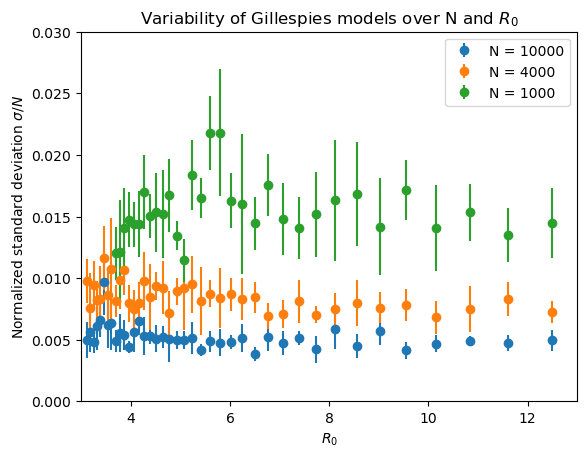

In [26]:
R0_space = beta / gamma_space
plt.errorbar(R0_space, stdev_list_10k, yerr=stdev_std_10k, fmt="o", label="N = 10000")
plt.errorbar(R0_space, stdev_list_4k, yerr=stdev_std_4k, fmt="o", label="N = 4000")
plt.errorbar(R0_space[0:gamma_limit_1k], stdev_list_1k, yerr=stdev_std_1k, fmt="o", label="N = 1000")

plt.xlabel("$R_0$")
plt.ylabel("Normalized standard deviation $\\sigma/N$")
plt.title("Variability of Gillespies models over N and $R_0$")
plt.legend()
plt.ylim(0, 0.03)
plt.xlim(3, 13)
plt.plot()

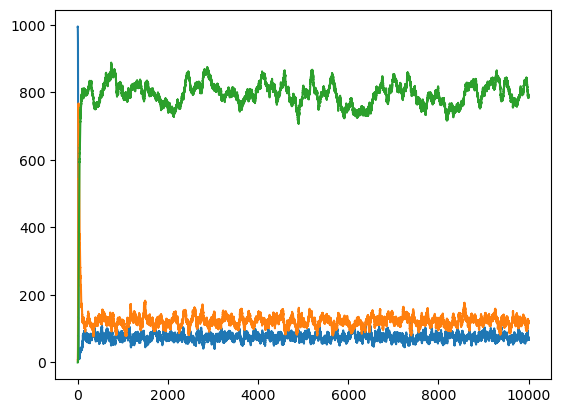

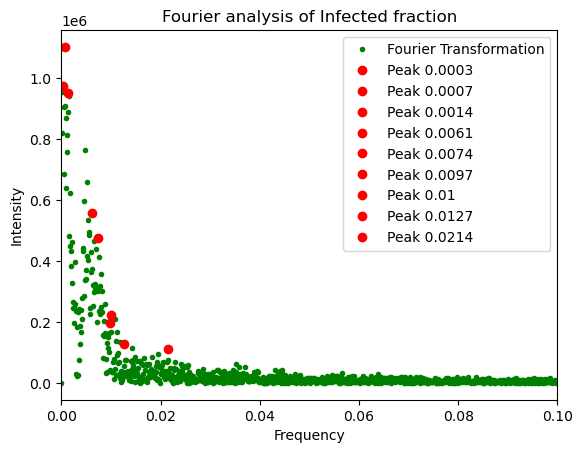

In [ ]:
# Initial Values
X0 = 995  
Y0 = 5
Z0 = 0
N = X0 + Y0 + Z0
beta = 0.5
gamma = 0.033
mu = 0.005
maxTime = 10000

model = SIRModelGillespies(X0, Y0, Z0, N, beta, gamma, mu)
model.gillespiesSimulation(maxTime)

plt.plot(model.results.time, model.results.S_List, label='S')
plt.plot(model.results.time, model.results.I_List, label='I')
plt.plot(model.results.time, model.results.R_List, label='R')
plt.show()
averageTimeStepSize = np.diff(np.array(model.results.time)).mean()

fourierOnSeries(model.results.I_List, averageTimeStepSize)

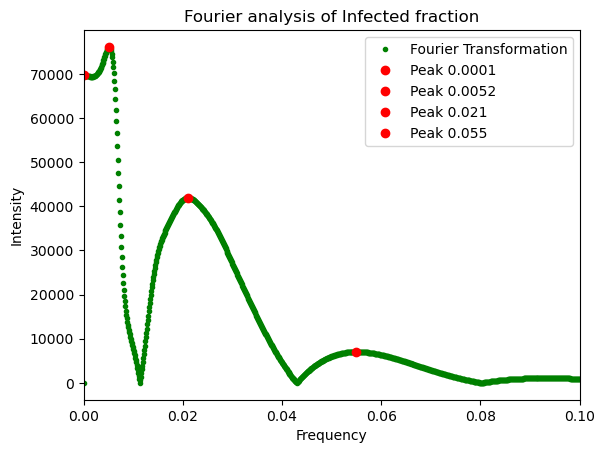

In [165]:
deterministicModel = SIRModelDeterministic(995, 5, 0, 1000, 0.5, 0.1, 0.005, 0.1, 10000)
deterministicModel.SIRModel()
fourierOnSeries(deterministicModel.results.I_List, deterministicModel.timeInterval, height=3000)

In [115]:
periodic = np.sin(2*np.pi*np.linspace(0, 1000, 10000))
print(f"{periodic = }")
print(f"{np.std(periodic) = }")
random = np.random.random(10000) * 2 - 1
print(f"{random = }")
print(f"{np.std(random) = }")

periodic = array([ 0.00000000e+00,  5.87836088e-01,  9.51095345e-01, ...,
       -9.51095345e-01, -5.87836088e-01, -6.42833292e-13])
np.std(periodic) = 0.7070714249635606
random = array([ 0.62934082,  0.25490719, -0.86770568, ...,  0.51847643,
       -0.72650842, -0.11322986])
np.std(random) = 0.578163726167071
